Original Image Matrix (Top-left 2x2):
[[[ 71  64  49]
  [123 115  91]]

 [[  3   0   0]
  [ 22  13   4]]]

Quantum Walk Probability Matrix (Top-left 2x2):
[[[36 36 36]
  [37 37 37]]

 [[37 37 37]
  [38 38 38]]]

C1 after Bitwise XOR (Top-left 2x2):
[[[ 99 100  21]
  [ 94  86 126]]

 [[ 38  37  37]
  [ 48  43  34]]]

Henon Map Indices (Top 10):
[254219 250559  76239 148881   8621  70175  59494 226617 153067 261486]

C2 after Henon Map Permutation (Top-left 2x2):
[[[ 13  11  40]
  [ 82  90 127]]

 [[121 127  87]
  [  7  13  37]]]

C3 after Bitwise Shift Right (Top-left 2x2):
[[[175  52  11]
  [ 61  51  27]]

 [[ 69 113 124]
  [122 112  88]]]

Encrypted Image Matrix (Top-left 2x2):
[[[175  52  11]
  [221 215 255]]

 [[245  26  34]
  [ 72  70 110]]]


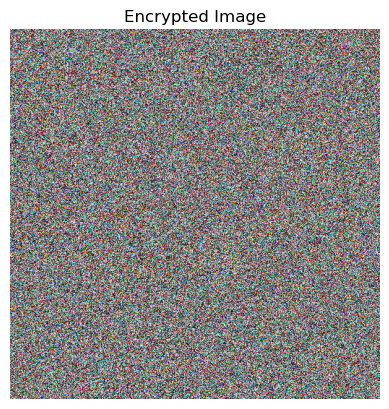


Decrypted Image Matrix (Top-left 2x2):
[[[ 71  64  49]
  [123 115  91]]

 [[  3   0   0]
  [ 22  13   4]]]


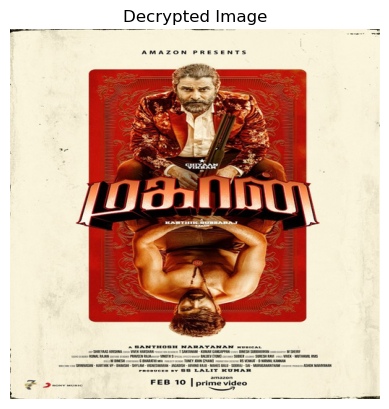


=== Step 7: Final Matching and Validation ===
→ Total Pixels Compared: 262144
→ Matching Pixels: 262144
→ Match Percentage: 100.00%


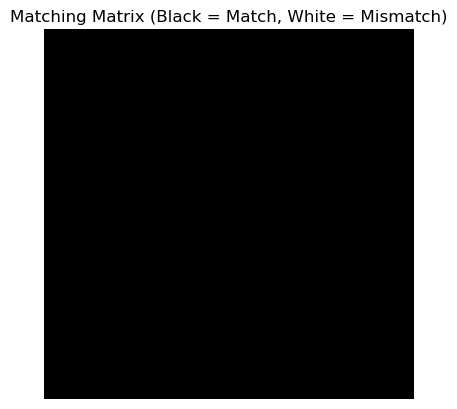


⏱️ Encryption Time: 123.8742 seconds | Decryption Time: 127.4431 seconds

✅ Decryption Successful: Decrypted image matches the original!


In [109]:
import numpy as np
from PIL import Image
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
import time
# Preprocess image
def preprocess_image(input_path, output_size=(512, 512)):
    img = Image.open(input_path).convert("RGB").resize(output_size, Image.LANCZOS)
    return np.array(img, dtype=np.uint8)

# Compute θ1, θ2, θ3
def compute_theta(img):
    total_pixels = img.shape[0] * img.shape[1]
    proportions = [np.sum(img[:, :, c]) / (255 * total_pixels) for c in range(3)]
    return proportions  # θ1, θ2, θ3

# Quantum walk probability matrix
def quantum_walk_probability_matrix_real(N, theta1, theta2):
    qr = QuantumRegister(4)
    qc = QuantumCircuit(qr)

    qc.h(qr[2])
    qc.h(qr[3])
    qc.x(qr[0])

    for _ in range(N):
        qc.ry(2 * np.pi * theta1, qr[2])
        qc.ry(2 * np.pi * theta2, qr[3])

        qc.cx(qr[2], qr[0])
        qc.x(qr[2])

        qc.ccx(qr[2], qr[3], qr[0])
        qc.x(qr[2])

        qc.ccx(qr[3], qr[2], qr[1])
        qc.x(qr[3])

        qc.ccx(qr[2], qr[3], qr[1])
        qc.x(qr[3])

    sv = Statevector.from_instruction(qc)
    probs = sv.probabilities_dict()
    prob_list = [probs.get(f'{i:04b}', 0) for i in range(16)]
    matrix = np.array(prob_list).reshape(4, 4)
    return matrix

# Generate RP matrix
def generate_rp_matrix(img_array, θ1, θ2, N=6):
    P = quantum_walk_probability_matrix_real(N, θ1, θ2)
    P_resized = np.array(Image.fromarray((P * 255).astype(np.uint8)).resize(img_array.shape[:2][::-1], Image.LANCZOS))
    spatial_variation = np.indices(img_array.shape[:2]).sum(axis=0) % 256
    return np.stack([(P_resized + spatial_variation) % 256] * 3, axis=2).astype(np.uint8)

# Bitwise XOR
def bitwise_xor(img_array, rp_matrix):
    return np.bitwise_xor(img_array, rp_matrix)

# Henon Map
def henon_map_indices(rows, cols, x0, y0):
    num_pixels = rows * cols
    x, y = x0, y0
    henon_points = []
    for _ in range(num_pixels):
        x_new = 1 - 1.4 * x * x + y
        y_new = 0.3 * x
        x, y = x_new, y_new
        henon_points.append((x, y))
    indices = np.argsort([x**2 + y**2 for x, y in henon_points])
    return indices

def henon_map_permutation(img_array, indices):
    rows, cols, _ = img_array.shape
    permuted = np.copy(img_array)
    for c in range(3):
        flat_pixels = img_array[:, :, c].flatten()
        permuted[:, :, c] = flat_pixels[indices].reshape((rows, cols))
    return permuted

# Bitwise shifts
def bitwise_shift_right(img_array, k1):
    return np.roll(img_array, shift=k1, axis=1)

def bitwise_shift_left(img_array, k1):
    return np.roll(img_array, shift=-k1, axis=1)

# Arnold Cat Map
def arnold_cat_map(img_array, iterations=1):
    rows, cols, _ = img_array.shape
    permuted = np.copy(img_array)
    for c in range(3):
        temp = img_array[:, :, c]
        for _ in range(iterations):
            new_image = np.zeros_like(temp)
            for x in range(rows):
                for y in range(cols):
                    x_new, y_new = (2 * x + y) % rows, (x + y) % cols
                    new_image[x_new, y_new] = temp[x, y]
            temp = new_image
        permuted[:, :, c] = temp
    return permuted

def inverse_arnold_cat_map(img_array, iterations=1):
    rows, cols, _ = img_array.shape
    permuted = np.copy(img_array)
    for c in range(3):
        temp = img_array[:, :, c]
        for _ in range(iterations):
            new_image = np.zeros_like(temp)
            for x in range(rows):
                for y in range(cols):
                    x_new, y_new = ((x - y) % rows, (-x + 2 * y) % cols)
                    new_image[x_new, y_new] = temp[x, y]
            temp = new_image
        permuted[:, :, c] = temp
    return permuted

# Decrypt
def decrypt_image(img_array, inverse_indices):
    rows, cols, _ = img_array.shape
    permuted = np.copy(img_array)
    for c in range(3):
        flat_pixels = img_array[:, :, c].flatten()
        permuted[:, :, c] = flat_pixels[inverse_indices].reshape((rows, cols))
    return permuted


input_path = "mahaan.jpg"
output_path_encrypted = "encrypted.jpg"
output_path_decrypted = "decrypted.jpg"

start_total = time.time()

img = preprocess_image(input_path)
rows, cols, _ = img.shape

θ1, θ2, θ3 = compute_theta(img)
rp_matrix = generate_rp_matrix(img, θ1, θ2)

print("Original Image Matrix (Top-left 2x2):")
print(img[:2, :2])

print("\nQuantum Walk Probability Matrix (Top-left 2x2):")
print(rp_matrix[:2, :2])

C1 = bitwise_xor(img, rp_matrix)
print("\nC1 after Bitwise XOR (Top-left 2x2):")
print(C1[:2, :2])

x0, y0 = θ3, θ3 / 2
indices = henon_map_indices(rows, cols, x0, y0)
print("\nHenon Map Indices (Top 10):")
print(indices[:10])

C2 = henon_map_permutation(C1, indices)
print("\nC2 after Henon Map Permutation (Top-left 2x2):")
print(C2[:2, :2])

K = θ1 + θ2 + θ3
k1 = int((K * 100) % 8)
C3 = bitwise_shift_right(C2, k1)
print("\nC3 after Bitwise Shift Right (Top-left 2x2):")
print(C3[:2, :2])

k2 = int(K * 100)
encrypted_img = arnold_cat_map(C3, iterations=k2)
encryption_end = time.time()

print("\nEncrypted Image Matrix (Top-left 2x2):")
print(encrypted_img[:2, :2])

Image.fromarray(encrypted_img).save(output_path_encrypted)
plt.imshow(encrypted_img)
plt.title("Encrypted Image")
plt.axis('off')
plt.show()

decrypted_img = inverse_arnold_cat_map(encrypted_img, iterations=k2)
decrypted_img = bitwise_shift_left(decrypted_img, k1)
inverse_indices = np.argsort(indices)
decrypted_img = decrypt_image(decrypted_img, inverse_indices)
decrypted_img = bitwise_xor(decrypted_img, rp_matrix)
end_total = time.time()

encryption_time = encryption_end - start_total
decryption_time = end_total - encryption_end

print("\nDecrypted Image Matrix (Top-left 2x2):")
print(decrypted_img[:2, :2])

Image.fromarray(decrypted_img).save(output_path_decrypted)
plt.imshow(decrypted_img)
plt.title("Decrypted Image")
plt.axis('off')
plt.show()

# === Step 7: Final Matching and Validation ===
print("\n=== Step 7: Final Matching and Validation ===")

# For RGB, check per pixel if all channels match
match_matrix = (img == decrypted_img)
per_pixel_match = np.all(match_matrix, axis=2)

match_count = np.sum(per_pixel_match)
total_count = per_pixel_match.size
match_percentage = (match_count / total_count) * 100

print(f"→ Total Pixels Compared: {total_count}")
print(f"→ Matching Pixels: {match_count}")
print(f"→ Match Percentage: {match_percentage:.2f}%")

# Show matrix difference as image (white=match, black=mismatch)
difference_matrix = np.where(per_pixel_match, 255, 0).astype(np.uint8)
diff_img = Image.fromarray(difference_matrix)
plt.imshow(diff_img, cmap='gray')
plt.title("Matching Matrix (Black = Match, White = Mismatch)")
plt.axis('off')
plt.show()

print(f"\n⏱️ Encryption Time: {encryption_time:.4f} seconds | Decryption Time: {decryption_time:.4f} seconds")

if np.array_equal(img, decrypted_img):
    print("\n✅ Decryption Successful: Decrypted image matches the original!")
else:
    print("\n❌ Decryption Failed: Decrypted image does not match the original!")




In [110]:
import numpy as np
from PIL import Image
import numpy as np

img = np.array(Image.open("mahaan.jpg").convert("RGB").resize((512,512)), dtype=np.uint8)
encrypted_img = np.array(Image.open("encrypted.jpg").convert("RGB").resize((512,512)), dtype=np.uint8)


def npcr(img1, img2):
    """
    Compute Number of Pixel Change Rate (NPCR) between two images.
    
    Args:
        img1, img2: numpy arrays of same shape
        
    Returns:
        NPCR value in percentage
    """
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same shape")
    
    diff = (img1 != img2).astype(np.int8)
    N = diff.size
    npcr_value = np.sum(diff) / N * 100
    return npcr_value

def uaci(img1, img2):
    """
    Compute Unified Average Changing Intensity (UACI) between two images.
    
    Args:
        img1, img2: numpy arrays of same shape
        
    Returns:
        UACI value in percentage
    """
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    diff = np.abs(img1 - img2)
    uacis = np.mean(diff / 255) * 100
    return uacis

# Example usage with your images:
npcr_value = npcr(img, encrypted_img)
uaci_value = uaci(img, encrypted_img)

print(f"NPCR: {npcr_value:.2f}%")
print(f"UACI: {uaci_value:.2f}%")


NPCR: 99.70%
UACI: 39.73%


In [111]:
import numpy as np
import cv2
from scipy.stats import pearsonr

def correlation_compact(image_array, image_name="image"):
    h, w, _ = image_array.shape

    directions = {
        "Horizontal": lambda x, y: (image_array[y, x], image_array[y, x + 1]),
        "Vertical":   lambda x, y: (image_array[y, x], image_array[y + 1, x]),
        "Diagonal":   lambda x, y: (image_array[y, x], image_array[y + 1, x + 1])
    }

    results = {"Horizontal": [], "Vertical": [], "Diagonal": []}

    for direction, sampler in directions.items():
        for c in range(3):  # BGR channels in OpenCV
            p1_vals, p2_vals = [], []

            for _ in range(5000):
                if direction == "Horizontal":
                    x = np.random.randint(0, w - 1)
                    y = np.random.randint(0, h)
                elif direction == "Vertical":
                    x = np.random.randint(0, w)
                    y = np.random.randint(0, h - 1)
                else:  # Diagonal
                    x = np.random.randint(0, w - 1)
                    y = np.random.randint(0, h - 1)

                p1, p2 = sampler(x, y)
                p1_vals.append(p1[c])
                p2_vals.append(p2[c])

            corr, _ = pearsonr(p1_vals, p2_vals)
            results[direction].append(round(corr, 4))

    # Print in required format
    print(f"{image_name:<15} ", end="")
    for direction in ["Horizontal", "Vertical", "Diagonal"]:
        r, g, b = results[direction][2], results[direction][1], results[direction][0]  # Reorder BGR to RGB
        print(f"{r:<6} {g:<6} {b:<6} ", end="")
    print()

print(f"{'Image Name':<15} {'Horizontal(RGB)':<20} {'Vertical(RGB)':<20} {'Diagonal(RGB)':<20}")
print("-" * 75)
correlation_compact(img, "Mahaan.jpg")

Image Name      Horizontal(RGB)      Vertical(RGB)        Diagonal(RGB)       
---------------------------------------------------------------------------
Mahaan.jpg      0.9822 0.9804 0.9622 0.973  0.974  0.944  0.9549 0.9597 0.9082 


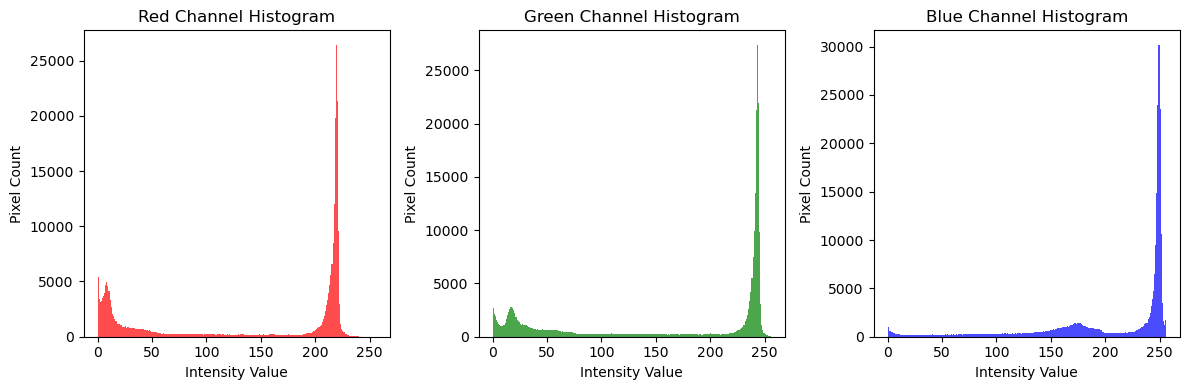

In [112]:
def histograms(image_array):
    # Convert BGR (OpenCV default) to RGB
    image_rgb = image_array[:, :, ::-1]

    # Split channels
    R, G, B = image_rgb[:, :, 0], image_rgb[:, :, 1], image_rgb[:, :, 2]

    # Plot histograms
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(R.ravel(), bins=256, range=(0, 256), color='red', alpha=0.7)
    plt.title('Red Channel Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Pixel Count')

    plt.subplot(1, 3, 2)
    plt.hist(G.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
    plt.title('Green Channel Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Pixel Count')

    plt.subplot(1, 3, 3)
    plt.hist(B.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.title('Blue Channel Histogram')
    plt.xlabel('Intensity Value')
    plt.ylabel('Pixel Count')

    plt.tight_layout()
    plt.show()
histograms(img)

In [113]:
import numpy as np

def calculate_entropy(channel_data):
    """Calculate entropy for a single image channel (2D array)."""
    histogram, _ = np.histogram(channel_data.flatten(), bins=256, range=(0, 256), density=True)
    histogram = histogram[histogram > 0]  # Remove zeros to avoid log2(0)
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

def analyze_entropy(image_array, title="Image"):
    """Calculate and print entropy of each RGB channel."""
    red_entropy = calculate_entropy(image_array[:, :, 0])
    green_entropy = calculate_entropy(image_array[:, :, 1])
    blue_entropy = calculate_entropy(image_array[:, :, 2])

    print(f"\n📊 Entropy Analysis for {title}:")
    print(f"→ Red Channel Entropy:   {red_entropy:.6f}")
    print(f"→ Green Channel Entropy: {green_entropy:.6f}")
    print(f"→ Blue Channel Entropy:  {blue_entropy:.6f}")

    average_entropy = (red_entropy + green_entropy + blue_entropy) / 3
    print(f"→ Average RGB Entropy:   {average_entropy:.6f}")

    return red_entropy, green_entropy, blue_entropy

# Assuming img and encrypted_img are your original and encrypted images as NumPy arrays
# Uncomment and run the following lines after defining img and encrypted_img:

analyze_entropy(img, title="Original Image")
analyze_entropy(encrypted_img, title="Encrypted Image")



📊 Entropy Analysis for Original Image:
→ Red Channel Entropy:   6.274636
→ Green Channel Entropy: 6.324667
→ Blue Channel Entropy:  6.139843
→ Average RGB Entropy:   6.246382

📊 Entropy Analysis for Encrypted Image:
→ Red Channel Entropy:   7.859252
→ Green Channel Entropy: 7.931235
→ Blue Channel Entropy:  7.915401
→ Average RGB Entropy:   7.901963


(7.859251948436555, 7.931234585221723, 7.915401472853504)

In [114]:
def decrypt_function(encrypted_img, k1, k2, inverse_indices, rp_matrix):
    # Step 1: Inverse Arnold Cat Map (decrypt)
    decrypted_img = inverse_arnold_cat_map(encrypted_img, iterations=k2)
    
    # Step 2: Bitwise shift left (undo right shift)
    decrypted_img = bitwise_shift_left(decrypted_img, k1)
    
    # Step 3: Henon map inverse permutation
    decrypted_img = decrypt_image(decrypted_img, inverse_indices)
    
    # Step 4: Bitwise XOR with RP matrix (undo XOR)
    decrypted_img = bitwise_xor(decrypted_img, rp_matrix)
    
    return decrypted_img


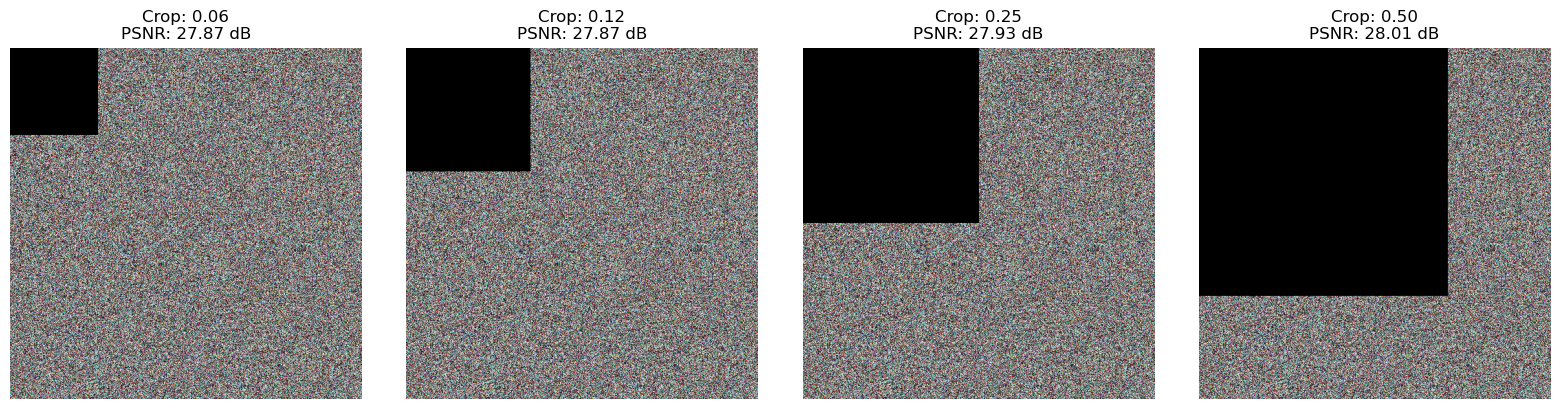

In [115]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# PSNR calculation
def compute_psnr(original, test):
    mse = np.mean((original - test) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 10 * np.log10((PIXEL_MAX ** 2) / mse)

# Crop attack implementation
def crop_image(img_array, crop_ratio):
    h, w, _ = img_array.shape
    crop_pixels = int(h * w * crop_ratio)
    crop_width = int(np.sqrt(crop_pixels))
    cropped = img_array.copy()
    cropped[0:crop_width, 0:crop_width] = 0
    return cropped

# Load images
original = np.array(Image.open("mahaan.jpg").convert("RGB").resize((512,512), Image.LANCZOS))
encrypted = np.array(Image.open("encrypted.jpg").convert("RGB"))

# Cropping ratios
crop_ratios = [1/16, 1/8, 1/4, 1/2]
cropped_images = []
psnr_scores = []
# Perform cropping attacks
for ratio in crop_ratios:
    cropped = crop_image(encrypted, ratio)
    cropattackimgs.append(cropped)
    psnr_value = compute_psnr(original, cropped)
    cropped_images.append(cropped)
    psnr_scores.append(psnr_value)

# Show results
fig, axs = plt.subplots(1, len(cropped_images), figsize=(16, 4))
for i, img in enumerate(cropped_images):
    axs[i].imshow(img)
    axs[i].set_title(f"Crop: {crop_ratios[i]:.2f}\nPSNR: {psnr_scores[i]:.2f} dB")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


Crop Ratio: 0.0625, PSNR: 28.22 dB


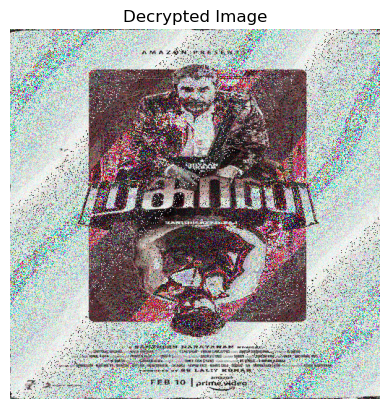

Crop Ratio: 0.1250, PSNR: 28.20 dB


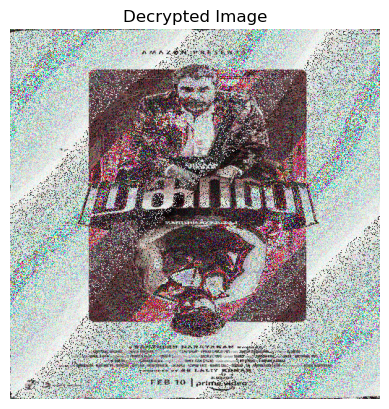

Crop Ratio: 0.2500, PSNR: 28.15 dB


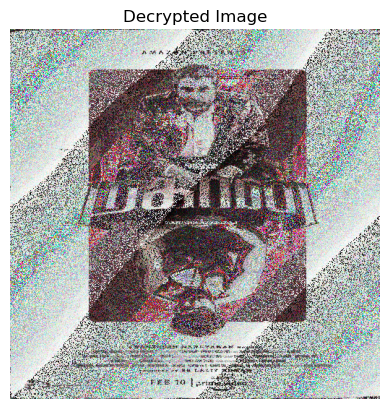

Crop Ratio: 0.5000, PSNR: 28.07 dB


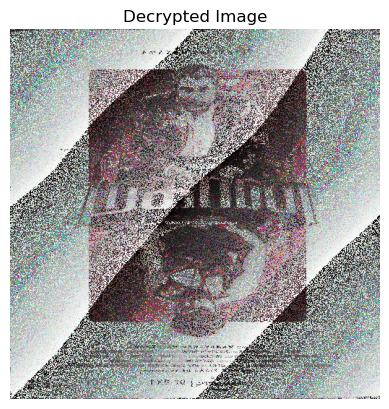

In [116]:
for i,ratio in zip(cropped_images,crop_ratios):
    decrypted_img = inverse_arnold_cat_map(i, iterations=k2)
    decrypted_img = bitwise_shift_left(decrypted_img, k1)
    inverse_indices = np.argsort(indices)
    decrypted_img = decrypt_image(decrypted_img, inverse_indices)
    decrypted_img = bitwise_xor(decrypted_img, rp_matrix)
    psnr_scores.append(psnr_value)
    psnr_value = compute_psnr(original, decrypted_img)
    print(f"Crop Ratio: {ratio:.4f}, PSNR: {psnr_value:.2f} dB")
    plt.imshow(decrypted_img)
    plt.title("Decrypted Image")
    plt.axis('off')
    plt.show()